In [1]:
import numpy as np
import pylab as plt
import pickle as pkl
import csv
import scipy.optimize, scipy.interpolate
import scipy.optimize as spop
import time

# Defining functions

## Fourier + tilt model

In [2]:
def fit(data, design, weights):
    N = len(design) # number of variational parameters
    sqrt_weights = np.sqrt(weights)
    
    # Incorporating weights, if given
    for i in range(len(design)): # absorbing weights in the design matrix
        design[i] = design[i]*sqrt_weights[i]
    
    data = data*sqrt_weights # absorbing into the data vector
    
    # Solving for fit parameters
    parameters = np.linalg.lstsq(design, data, rcond=None)[0]
    
    # Calculating model values
    model = np.matmul(design, parameters)

    # Calculating pointwise absolute errors
    error = np.abs(data - model)
    
    return parameters, model, error

def fourier_design(x_array, n_freq, L):
    'In (column) list, cosines followed sines.'
#     assert 2*n_freq < len(x_array)
    
    k0 = 2*np.pi/L
    
    output_cos = [np.cos(k0*i*x_array) for i in range(n_freq)]
    output_sin = [np.sin(k0*i*x_array) for i in range(1,n_freq)]
    
    return np.concatenate((output_cos, output_sin)).T


def fourier_design_ortho(data, x_labels, y_labels, n_x, n_y, L_x, L_y):
    assert len(x_labels) == len(y_labels)
    assert len(x_labels) == len(data.flatten())

    fdesign_x = fourier_design(x_labels,n_x, L_x)
    fdesign_y = fourier_design(y_labels,n_y, L_y)
    
    return fdesign_x, fdesign_y

def fourier_design_2D(x_array, y_array, n_kx, n_ky, L_x, L_y):
    
    # Grouping x_array and y_array into vectors
    xxs, yys = np.meshgrid(x_array, y_array)
    xxs_flat, yys_flat = xxs.flatten(), yys.flatten()
    xxs_tall, yys_tall = xxs_flat.reshape(len(xxs_flat),1), \
    yys_flat.reshape(len(yys_flat),1)
    r_vecs = np.concatenate((xxs_tall, yys_tall), axis=1)
    
    # Setting up k vectors
    kxs, kys = np.arange(-n_kx + 1, n_kx)/L_x, np.arange(0, n_ky)/L_y
    kxxs, kyys = np.meshgrid(kxs, kys)
    kxxs_flat, kyys_flat = kxxs.flatten(), kyys.flatten()
    kxxs_flat, kyys_flat = np.delete(kxxs_flat, int(n_kx - 1)), np.delete(kyys_flat, int(n_ky - 1)) # k=[0,0] removed
    kxxs_tall, kyys_tall = kxxs_flat.reshape(len(kxxs_flat),1), \
    kyys_flat.reshape(len(kyys_flat),1)
    k_vecs = 2*np.pi*np.concatenate((kxxs_tall, kyys_tall), axis=1) # does not include [0,0]!
    
    # Calculating matrix elements
    kDOTr = np.array([[np.dot(k_vec, r_vec) for k_vec in k_vecs] for r_vec in r_vecs])
    output_cos = np.cos(kDOTr)
    output_sin = np.sin(kDOTr)
    output = np.concatenate((np.ones((len(r_vecs),1)), output_cos), axis = 1)
    output = np.concatenate((output, output_sin), axis = 1) 
    
    return output, kxxs_flat, kyys_flat

def shear_parameter_cofactor(design, parameters, orthocoord_vals, ortho_factors, L):
    assert len(design) == len(orthocoord_vals)
    assert len(orthocoord_vals) == len(ortho_factors)
    assert len(design[0]) == len(parameters)

    # Number of frequency (already implied by design matrix size)
    n_freq = int((len(design[0]) + 1)/2)
    
    # Design square but with the constant column removed
    design_square = np.delete(design, 0, axis=1)
    
    
    # Wavenumbers with absorbed sign (does not include k = 0)
    ks_signed = np.array([2*np.pi*i/L for i in range(1,n_freq)] \
                  +[2*np.pi*i/L for i in range(1,n_freq)])
    signs = np.array([1 for i in range(1,n_freq)] \
                  +[-1 for i in range(1,n_freq)])
    ks_signed = ks_signed*signs
    
    # Fourier coefficients with k = 0 removed
    para_square = np.delete(parameters, 0)
    para_square_rolled = np.roll(para_square, -(n_freq-1))

    # Finishing calculation...
    ks_signed_times_pararolled = ks_signed*para_square_rolled
    output = np.matmul(design_square,ks_signed_times_pararolled)
    output = output*orthocoord_vals*ortho_factors
    return output

def shear(data, weight_factors, orthodir_vals, orthodir_factors,\
          sheardir_factors, sheardir_design, sheardir_para, sheardir_L):
    correction_terms = shear_parameter_cofactor(sheardir_design, sheardir_para,\
                                                 orthodir_vals, orthodir_factors, sheardir_L)
    residual = data - sheardir_factors*orthodir_factors
    output = np.dot(residual*weight_factors, correction_terms)/ \
    np.dot(correction_terms*weight_factors, correction_terms)
    
    return output

epsilon_matrix = lambda x : np.array([[1 - x[0], x[1]],[x[2], 1- x[3]]])

def minimize_2Dspec(data, n_x, n_y, n_iter, n_Fourier_iter = 1, n_deform_iter = 10):
    start_time = time.time()
    
    #XXXX Defining constants and local functions XXXX#
    N = len(data)*len(data[0])
    data_flat = data.flatten()
    L_x, L_y = 1, 1 # 2D-data normalized to unit square
    ##################################################
    
    
    #XXXX Initializing parameter and weight values XXXX#
    # Grid labels
    eta1_vals = np.arange(len(data[0]))/len(data[0]) # normalized to unit interval
    eta2_vals = np.arange(len(data[:,0]))/len(data[:,0]) # normalized to unit interval   
    eta1_mesh, eta2_mesh = np.meshgrid(eta1_vals,eta2_vals) # creating mesh
    eta1_flat, eta2_flat = eta1_mesh.flatten(), eta2_mesh.flatten() # vectorizing
    eta1_flat_ortho, eta2_flat_ortho = np.copy(eta1_flat), np.copy(eta2_flat) # storing orthogonal mesh
    
    # Fourier design matrices
    design_x, design_y = fourier_design_ortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
    
    # Fourier coefficients
    x, y = np.ones(2*n_x - 1), np.ones(2*n_y - 1)
    
    # Linear deformation parameters
    epsilon_xx, epsilon_xy, epsilon_yx, epsilon_yy = 0,0,0,0
    
    # Weights
    weights = np.ones_like(data_flat)
    ####################################################
    
    
    #XXXX Constructing handles for data model points XXXX#
    f = np.matmul(design_x,x) #function along the horizontal (x) evaluations
    g = np.matmul(design_y,y) #function along the vertical (y) evaluations
    ######################################################
    
    
    counter = 0
    
    while counter < n_iter:        
        counter += 1
        print(f'Iteration {counter}:')
        
        ##### Fourier fitting ##### 
        
        for i in range(n_Fourier_iter):

            ##### Solving f(x) parameters #####
            # Updating parameters
            design = np.array([design_x[i]*g[i] for i in range(len(design_x))])
            x = fit(data_flat, design, weights)[0]

            # Updating model-related values
            f = np.matmul(design_x,x)
            errors = np.abs(data_flat - np.matmul(design,x))
            weights = (1/np.clip(errors, 0.000000000001, None))
            ###################################


            ##### Solving g(y) parameters #####
            # Updating parameters
            design = np.array([design_y[i]*f[i] for i in range(len(design_y))])
            y = fit(data_flat, design, weights)[0]

            # Updating model-related values
            g = np.matmul(design_y,y)
            errors = np.abs(data_flat - np.matmul(design,y))
            weights = 1/np.clip(errors, 0.000000000001, None)
            ###################################

        
        ###########################
        
        
        ##### Grid shearing #####
        for i in range(n_deform_iter):
            
            ##### Shearing along x #####           
            epsilon_xy += shear(data_flat, weights, eta2_flat, g, f, design_x, x, 1)
            deformation_matrix = epsilon_matrix([0,epsilon_xy,0,0])
            
            etas_stacked = np.vstack((eta1_flat_ortho,eta2_flat_ortho)) 
            etas_stacked = np.matmul(deformation_matrix, etas_stacked)    
            eta1_flat[:] = etas_stacked[0,:]
            eta2_flat[:] = etas_stacked[1,:]
            
            design_x, design_y = fourier_design_ortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
            f, g = np.matmul(design_x,x), np.matmul(design_y,y)
            errors = np.abs(data_flat - f*g)
            weights = 1/np.clip(errors, 0.000000000001, None)
            ############################
            
        for i in range(n_deform_iter):
            
            ##### Shearing along y #####           
            epsilon_yx += shear(data_flat, weights, eta1_flat, f, g, design_y, y, 1)
            deformation_matrix = epsilon_matrix([0,epsilon_xy,epsilon_yx,0])
            
            etas_stacked = np.vstack((eta1_flat_ortho,eta2_flat_ortho)) 
            etas_stacked = np.matmul(deformation_matrix, etas_stacked)    
            eta1_flat[:] = etas_stacked[0,:]
            eta2_flat[:] = etas_stacked[1,:]
            
            design_x, design_y = fourier_design_ortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
            f, g = np.matmul(design_x,x), np.matmul(design_y,y)
            errors = np.abs(data_flat - f*g)
            weights = 1/np.clip(errors, 0.000000000001, None)
            ############################  
        #########################
        
        
        ##### Plotting intermediate models #####
        
        model = f*g
        residue = data_flat - model
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(model.reshape(np.shape(data)), origin='lower')
        im2 = ax2.imshow(residue.reshape(np.shape(data)), vmax = 0.2 ,origin='lower')
        ax1.set_title('model')
        ax2.set_title('residue')
        fig.colorbar(im1, ax=ax1, shrink=0.6)
        fig.colorbar(im2, ax=ax2, shrink=0.6)
        fig.tight_layout()
        plt.show()
        ########################################
        
    
    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    
    return x, y, epsilon_xy, epsilon_yx

def minimize_2Dspec_maximal(data, n_iter, n_Fourier_iter = 1, n_deform_iter = 10):
    n_freq_x, n_freq_y = int(len(data[0])/2), int(len(data)/2)
    return minimize_2Dspec(data, n_freq_x, n_freq_y, n_iter, \
                           n_Fourier_iter = 1, n_deform_iter = 10)

## Scipy-infused version

In [3]:
def minimize_2Dspec_scipy(data, n_x, n_y, n_iter, n_Fourier_iter = 1, n_deform_iter = 10):
    start_time = time.time()
    
    #XXXX Defining constants and local functions XXXX#
    N = len(data)*len(data[0])
    data_flat = data.flatten()
    L_x, L_y = 1, 1 # 2D-data normalized to unit square
    ##################################################
    
    
    #XXXX Initializing parameter and weight values XXXX#
    # Grid labels
    eta1_vals = np.arange(len(data[0]))/len(data[0]) # normalized to unit interval
    eta2_vals = np.arange(len(data[:,0]))/len(data[:,0]) # normalized to unit interval   
    eta1_mesh, eta2_mesh = np.meshgrid(eta1_vals,eta2_vals) # creating mesh
    eta1_flat, eta2_flat = eta1_mesh.flatten(), eta2_mesh.flatten() # vectorizing
    eta1_flat_ortho, eta2_flat_ortho = np.copy(eta1_flat), np.copy(eta2_flat) # storing orthogonal mesh
    
    # Fourier design matrices
    design_x, design_y = fourier_design_ortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
    
    # Fourier coefficients
    x, y = np.ones(2*n_x - 1), np.ones(2*n_y - 1)
    
    # Linear deformation parameters
    epsilon_xx, epsilon_xy, epsilon_yx, epsilon_yy = 0,0,0,0
    
    # Weights
    weights = np.ones_like(data_flat)
    ####################################################
    
    
    #XXXX Constructing handles for data model points XXXX#
    f = np.matmul(design_x,x) #function along the horizontal (x) evaluations
    g = np.matmul(design_y,y) #function along the vertical (y) evaluations
    ######################################################
    
    
    counter = 0
    
    while counter < n_iter:        
        counter += 1
        print(f'Iteration {counter}:')
        
        ##### Fourier fitting ##### 
        
        for i in range(n_Fourier_iter):

            ##### Solving f(x) parameters #####
            # Updating parameters
            design = np.array([design_x[i]*g[i] for i in range(len(design_x))])
            x = fit(data_flat, design, weights)[0]

            # Updating model-related values
            f = np.matmul(design_x,x)
            errors = np.abs(data_flat - np.matmul(design,x))
            weights = (1/np.clip(errors, 0.000000000001, None))
            ###################################


            ##### Solving g(y) parameters #####
            # Updating parameters
            design = np.array([design_y[i]*f[i] for i in range(len(design_y))])
            y = fit(data_flat, design, weights)[0]

            # Updating model-related values
            g = np.matmul(design_y,y)
            errors = np.abs(data_flat - np.matmul(design,y))
            weights = 1/np.clip(errors, 0.000000000001, None)
            ###################################

        
        ###########################
        
            
        ##### Solving shear parameter along x #####           
        epsilon_xy, epsilon_yx = scipy.optimize.minimize(cost,[0,0],args=(data,x,y,weights)).x
        deformation_matrix = epsilon_matrix([0,epsilon_xy,epsilon_yx,0])
        ###########################################

        ##### Deforming grid #####
        etas_stacked = np.vstack((eta1_flat_ortho,eta2_flat_ortho)) 
        etas_stacked = np.matmul(deformation_matrix, etas_stacked)    
        eta1_flat[:] = etas_stacked[0,:]
        eta2_flat[:] = etas_stacked[1,:]
        ##########################

        ##### Updating values #####
        design_x, design_y = fourier_design_ortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
        f, g = np.matmul(design_x,x), np.matmul(design_y,y)
        errors = np.abs(data_flat - f*g)
        weights = 1/np.clip(errors, 0.000000000001, None)
        ############################################
        
        #########################
        
        
        ##### Plotting intermediate models #####
        
        model = f*g
        residue = data_flat - model
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(model.reshape(np.shape(data)), origin='lower')
        im2 = ax2.imshow(residue.reshape(np.shape(data)), vmax = 2 ,origin='lower')
        ax1.set_title('model')
        ax2.set_title('residue')
        fig.colorbar(im1, ax=ax1, shrink=0.6)
        fig.colorbar(im2, ax=ax2, shrink=0.6)
        fig.tight_layout()
        plt.show()
        ########################################
        
    
    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    
    return x, y, epsilon_xy, epsilon_yx, weights

def minimize_2Dspec_maximal_scipy(data, n_iter, n_Fourier_iter = 1, n_deform_iter = 10):
    n_freq_x, n_freq_y = int(len(data[0])/2), int(len(data)/2)
    return minimize_2Dspec_scipy(data, n_freq_x, n_freq_y, n_iter, \
                           n_Fourier_iter = 1, n_deform_iter = 10)

## Discrete outer product model

In [4]:
def minimize_ptp(data, init_guess, tol, n_it):
    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    len_y = len(data) 
    
    # Initializing arrays and values
    y = np.empty(len(init_guess[:len_y]))
    x = np.empty(len(init_guess[len_y:]))
    y_prev = np.empty(len(init_guess[:len_y]))
    x_prev = np.empty(len(init_guess[len_y:]))
    y_prev[:] = init_guess[:len_y]
    x_prev[:] = init_guess[len_y:]
    sqerror = np.ones_like(data)
    
    counter = 0
    lsq = 1
    
    while ( lsq > tol and counter < n_it ) or counter == 1:
        counter += 1

        # Updating parameters
        for i in range(len(x)):
            x[i] = np.matmul(y_prev,data/sqerror)[i]/np.matmul(y_prev**2,1/sqerror)[i]
        for i in range(len(y)):
            y[i] = np.matmul(data/sqerror,x_prev)[i]/np.matmul(1/sqerror,x_prev**2)[i]
        
        # Updating previous guess
        
        y_prev[:] = y[:]
        x_prev[:] = x[:]
        
        # Updating squared error matrix; removing zeroes
        sqerror = np.abs((data - np.outer(y,x)))
        sqerror = np.clip(sqerror, 0.000000000001, None)

        lsq = np.sum(sqerror)/N**2
        
#         print(f'{lsq}/{tol}, {counter}')

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

# Simulated data

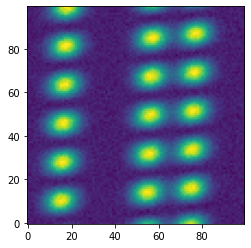

In [5]:
m_xy = -0.03
m_yx = -0.03*np.pi

xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
    return 1*(np.sin(2*np.pi*(yy + xx*m_yx)/(2.5/7)))**2*\
(np.exp(-(xx + yy*m_xy -0.15)**2/0.005)+np.exp(-(xx + yy*m_xy -0.55)**2/0.005)\
+np.exp(-(xx + yy*m_xy -0.75)**2/0.005))
#     return np.exp(-(xx + yy*(-0.08) - 0.5)**2/0.05)

data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (1/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 0*cosmic_rays

plt.imshow(data_sim, origin='lower', vmax=1)
plt.show()

In [8]:
# Creating pointwise ortho model
initial_guess = np.ones(len(data_sim) + len(data_sim[0]))
y_model, x_model = minimize_ptp(data_sim, initial_guess, 0.0000000001, 200)
data_model_ptp = np.outer(y_model,x_model)

# Creating Fourier model

xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

deform = np.array([[1,fit_parameters[2]],[fit_parameters[3],1]])

xys_stacked = np.vstack((xxs_flat,yys_flat)) 
xys_stacked = np.matmul(deform, xys_stacked)    
eta1s = xys_stacked[0]
eta2s = xys_stacked[1]

design_y_test = fourier_design(eta2s, 50, 1)
design_x_test = fourier_design(eta1s, 50, 1)

y_hat = np.matmul(design_y_test,fit_parameters[1])
x_hat = np.matmul(design_x_test,fit_parameters[0])

data_model_fourier = y_hat*x_hat
data_model_fourier = data_model_fourier.reshape(np.shape(data_sim))

# Plotting...

fig, axs = plt.subplots(2,2, figsize=(7,7))
im1 = axs[0,0].imshow(data_sim, vmax = 1, origin='lower')
im2 = axs[0,1].imshow(data_model_ptp, origin='lower')
im3 = axs[1,0].imshow(data_model_fourier, origin='lower')
im4 = axs[1,1].imshow(data_sim - data_model_fourier, origin='lower')
axs[0,0].set_title('data')
axs[0,1].set_title('pointwise orhto')
axs[1,0].set_title('model')
axs[1,1].set_title('model residue')
plt.colorbar(im1, ax = axs[0,0], shrink = 1)
plt.colorbar(im2, ax = axs[0,1], shrink = 1)
plt.colorbar(im3, ax = axs[1,0], shrink = 1)
plt.colorbar(im4, ax = axs[1,1], shrink = 1)
fig.tight_layout()
plt.show()

Time elapsed is 2.1651721000671387. Iterations: 200.


NameError: name 'fit_parameters' is not defined

# APOGEE data

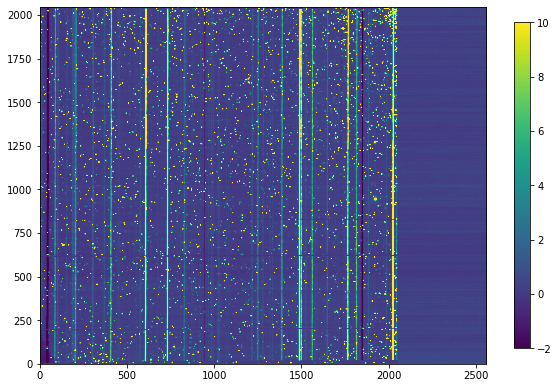

In [3]:
from astropy.io import fits

UNe_arc = fits.open("apR-a-27310005.fits")
data_actualx = UNe_arc[0].data

plt.figure(figsize=(10,10))
plt.imshow(data_actualx, vmin=-2, vmax=10, origin='lower')
plt.colorbar(shrink=0.6)
# plt.xlim(1000,1500)
# plt.ylim(650,750)
plt.show()

## Calibration lines list

In [ ]:
xpix_chipnum1 = [11.83,
47.65,
90.78,
156.45,
192.24,
200.55,
208.09,
372.78,
410.50,
445.72,
455.44,
559.02,
577.59,
584.76,
679.23,
733.55,
792.02,
825.20,
830.95,
872.14,
881.42,
895.53,
916.37,
918.46,
940.72,
944.20,
953.51,
968.75,
978.77,
984.15,
994.98,
1017.72,
1026.76,
1041.71,
1065.25,
1069.92,
1082.56,
1161.79,
1216.08,
1246.64,
1250.39,
1278.98,
1318.63,
1333.56,
1387.15,
1469.38,
1472.84,
1487.79,
1497.39,
1523.94,
1560.58,
1576.59,
1590.31,
1600.67,
1617.12,
1646.11,
1659.44,
1709.20,
1729.53,
1764.00,
1806.14,
1813.60,
1816.92,
1830.73,
1846.41,
1863.79,
1880.54,
1894.51,
1921.42,
1977.04,
1985.48,
2022.38,
2032.44]

## Smaller section

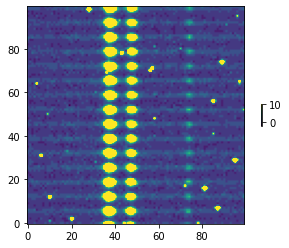

In [4]:
west_end = 1450
east_end = 1550
apogee_span = east_end - west_end

data_actual = UNe_arc[0].data[1650:1750,west_end:east_end]
plt.figure()
plt.imshow(data_actual, vmin=-2, vmax=10, origin='lower')
plt.colorbar(shrink=0.1)
plt.show()

In [ ]:
fit_parameters = minimize_2Dspec_maximal(data_actual, 40, 10, 10)

In [ ]:
### PTP minimization ###
initial_guess = np.ones(len(data_sim) + len(data_sim[0]))
y_model, x_model = minimize_ptp(data_actual, initial_guess, 0.0000000001, 20)
data_model_ptp = np.outer(y_model,x_model)

# Plotting model

xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

deform = np.array([[1,fit_parameters[2]],[fit_parameters[3],1]])

xys_stacked = np.vstack((xxs_flat,yys_flat)) 
xys_stacked = np.matmul(deform, xys_stacked)    
eta1s = xys_stacked[0]
eta2s = xys_stacked[1]

design_y1_test = fourier_design(eta2s, 50, 1)
design_x1_test = fourier_design(eta1s, 50, 1)

y_hat1 = np.matmul(design_y1_test,fit_parameters[1])
x_hat1 = np.matmul(design_x1_test,fit_parameters[0])

data_model_fourier1 = y_hat1*x_hat1
data_model_fourier1 = data_model_fourier1.reshape(np.shape(data_sim))
plt.title('Model from rotated etas')
plt.imshow(data_model_fourier1, origin='lower')
plt.colorbar()
plt.show()

fig, axs = plt.subplots(1,2)
im1 = axs[0].imshow(data_actual - data_model_fourier1, vmax=10, vmin=-10, origin='lower')
axs[0].set_title('with shear')
plt.colorbar(im1, ax=axs[0], shrink=0.5)
im2 = axs[1].imshow(data_actual - data_model_ptp, origin='lower', vmax=10, vmin=-10)
axs[1].set_title('pointwise w/o shear')
plt.colorbar(im2, ax=axs[1], shrink=0.5)
plt.tight_layout()

# Sketch (shear field)

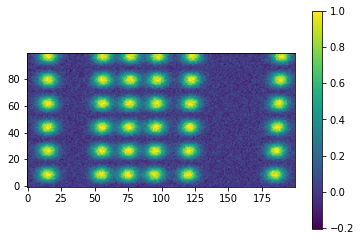

In [220]:
m_xy = -0.03
m_yx = -0.03*np.pi*0

xs = np.linspace(0,2,200)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
    return 1*(np.sin(2*np.pi*(yy + xx*m_yx)/(2.5/7)))**2*\
(np.exp(-(xx + yy*m_xy*0.15 -0.15)**2/0.005)+\
 np.exp(-(xx + yy*m_xy*0.55 -0.55)**2/0.005)+\
 np.exp(-(xx + yy*m_xy*0.75 -0.75)**2/0.005)+\
 np.exp(-(xx + yy*m_xy*0.95 -0.95)**2/0.005)+\
 np.exp(-(xx + yy*m_xy*1.20 -1.20)**2/0.005)+\
 np.exp(-(xx + yy*m_xy*1.85 -1.85)**2/0.005)
)


data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (1/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0])) + 0*cosmic_rays

plt.imshow(data_sim, origin='lower', vmax=1)
plt.colorbar()
plt.show()

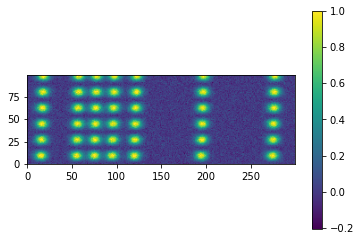

In [199]:
m_xy = -0.03
m_yx = -0.03*np.pi*0

xs = np.linspace(0,3,300)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
    return 1*(np.sin(2*np.pi*(yy + xx*m_yx)/(2.5/7)))**2*\
(np.exp(-(xx + yy*m_xy -0.15)**2/0.005)+\
 np.exp(-(xx + yy*m_xy -0.55)**2/0.005)+\
 np.exp(-(xx + yy*m_xy -0.75)**2/0.005)+\
 np.exp(-(xx + yy*m_xy -0.95)**2/0.005)+\
 np.exp(-(xx + yy*m_xy -1.20)**2/0.005)+\
 np.exp(-(xx + yy*m_xy -1.95)**2/0.005)+\
 np.exp(-(xx + yy*m_xy -2.75)**2/0.005)
)


data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (1/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0])) + 0*cosmic_rays

plt.imshow(data_sim, origin='lower', vmax=1)
plt.colorbar()
plt.show()

In [99]:
def fourier_design_2D_module(x_array, y_array, n_kx, n_ky, L_x, L_y):
    
    # Grouping x_array and y_array into vectors
    xxs_tall, yys_tall = x_array.reshape(len(x_array),1), \
    y_array.reshape(len(y_array),1)
    r_vecs = np.concatenate((xxs_tall, yys_tall), axis=1)
    k_vecs = np.array([[i,0] for i in range(1, n_kx)])

    
    kxxs_flat, kyys_flat = k_vecs[:,0], k_vecs[:,1]
    
#     # Setting up k vectors
#     kxs, kys = np.arange(-n_kx + 1, n_kx)/L_x, np.arange(0, n_ky)/L_y
#     kxxs, kyys = np.meshgrid(kxs, kys)
#     kxxs_flat, kyys_flat = kxxs.flatten(), kyys.flatten()
#     kxxs_flat, kyys_flat = np.delete(kxxs_flat, int(n_kx - 1)), np.delete(kyys_flat, int(n_ky - 1)) # k=[0,0] removed
#     kxxs_tall, kyys_tall = kxxs_flat.reshape(len(kxxs_flat),1), \
#     kyys_flat.reshape(len(kyys_flat),1)
#     k_vecs = 2*np.pi*np.concatenate((kxxs_tall, kyys_tall), axis=1) # does not include [0,0]!
    
    # Calculating matrix elements
    kDOTr = np.array([[np.dot(k_vec, r_vec) for k_vec in k_vecs] for r_vec in r_vecs])
    output_cos = np.cos(kDOTr)
    output_sin = np.sin(kDOTr)
    output = np.concatenate((np.ones((len(r_vecs),1)), output_cos), axis = 1)
    output = np.concatenate((output, output_sin), axis = 1) 
    
    return output, kxxs_flat, kyys_flat

# def deform_local(x_array, y_array, epsilon_xys, epsilon_yxs):
#     x_out = []
#     y_out = []
    
#     for i in range(len(x_array)):
#         r_new = np.matmul(epsilon_matrix([0,epsilon_xys[i],epsilon_yxs[i],0]), [x_array[i],y_array[i]])
#         x_out.append(r_new[0])
#         y_out.append(r_new[1])
    
#     return np.array(x_out), np.array(y_out)

def deform_local(x_array, y_array, epsilon_xys, epsilon_yxs):    
    return x_array + epsilon_xys*y_array, y_array + epsilon_yxs*x_array

def minimize_2Dspec_fouriershear(data, n_x, n_y, n_iter, n_Fourier_iter = 1, n_deform_iter = 1):
    start_time = time.time()
    
    #XXXX Defining constants and local functions XXXX#
    N = len(data)*len(data[0])
    data_flat = data.flatten()
    data_mean = np.mean(data_flat)
    L_x, L_y = 1, 1 # 2D-data normalized to unit square
    ##################################################
    
    
    #XXXX Initializing parameter and weight values XXXX#
    # Grid labels
    eta1_vals = np.arange(len(data[0]))/len(data[0]) # normalized to unit interval
    eta2_vals = np.arange(len(data[:,0]))/len(data[:,0]) # normalized to unit interval   
    eta1_mesh, eta2_mesh = np.meshgrid(eta1_vals,eta2_vals) # creating mesh
    eta1_flat, eta2_flat = eta1_mesh.flatten(), eta2_mesh.flatten() # vectorizing
    eta1_flat_ortho, eta2_flat_ortho = np.copy(eta1_flat), np.copy(eta2_flat) # storing orthogonal mesh
    
    # Fourier design matrices
    design_x, design_y = fourier_design_ortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
    
    # Fourier coefficients
    x, y = np.zeros(2*n_x - 1), np.zeros(2*n_y - 1)
    x[0], y[0], = 1, 1
    
    # Linear deformation parameters
    epsilon_xxs = np.zeros_like(data_flat)
    epsilon_xys = np.zeros_like(data_flat)
    epsilon_yxs = np.zeros_like(data_flat)
    epsilon_yys = np.zeros_like(data_flat)
    
    # Weights
    weights = np.ones_like(data_flat)
    ####################################################
    
    
    #XXXX Constructing handles for data model points XXXX#
    f = np.matmul(design_x,x) #function along the horizontal (x) evaluations
    g = np.matmul(design_y,y) #function along the vertical (y) evaluations
    ######################################################
    
    
    counter = 0
    
    while counter < n_iter:        
        counter += 1
        print(f'Iteration {counter}:')
        
        ##### Fourier fitting ##### 
        
        for i in range(n_Fourier_iter):

            ##### Solving f(x) parameters #####
            # Updating parameters
            design = np.array([design_x[i]*g[i] for i in range(len(design_x))])
            x = fit(data_flat, design, weights)[0]

            # Updating model-related values
            f = np.matmul(design_x,x)
            model_mean = np.mean(f*g)
            errors = np.abs(data_flat - np.matmul(design,x))
            weights = 1/np.clip(errors, model_mean, None)**2
            ###################################


            ##### Solving g(y) parameters #####
            # Updating parameters
            design = np.array([design_y[i]*f[i] for i in range(len(design_y))])
            y = fit(data_flat, design, weights)[0]

            # Updating model-related values
            g = np.matmul(design_y,y)
            model_mean = np.mean(f*g)
            errors = np.abs(data_flat - np.matmul(design,y))
            weights = 1/np.clip(errors, model_mean, None)**2
            ###################################

        
        ###########################
        
        
        ##### Grid shearing #####

        for i in range(n_deform_iter):
            
            ##### Shearing along x #####        
            design_shear, kxs, kys = fourier_design_2D_module(eta1_flat, eta2_flat, 25, 2, 1, 1)
            correction_terms = shear_parameter_cofactor(design_x, x, eta2_flat, g, 1)
            design = np.array([design_shear[i]*g[i]*correction_terms[i] for i in range(len(design))])            
            residual = data_flat - f*g        
            epsilon_xy_paras = fit(residual, design, weights)[0]           
            epsilon_xys += np.matmul(design_shear, epsilon_xy_paras)

            eta1_flat, eta2_flat = deform_local(eta1_flat_ortho, eta2_flat_ortho, epsilon_xys, epsilon_yxs)  
                         
            design_x, design_y = fourier_design_ortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
            f, g = np.matmul(design_x,x), np.matmul(design_y,y)
            errors = np.abs(data_flat - f*g)
            model_mean = np.mean(f*g)
            weights = 1/np.clip(errors, model_mean, None)**2
            ############################
            
        
        #### Plotting intermediate models #####
        
        model = f*g
        residue = data_flat - model
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(model.reshape(np.shape(data)), origin='lower')
        im2 = ax2.imshow(residue.reshape(np.shape(data)), vmax = 0.2 ,origin='lower')
        ax1.set_title('model')
        ax2.set_title('residue')
        fig.colorbar(im1, ax=ax1, shrink=0.6)
        fig.colorbar(im2, ax=ax2, shrink=0.6)
        fig.tight_layout()
        plt.show()
        print(np.average(np.abs(residue)))
        print(np.mean(epsilon_xys))
        #######################################
        
    
    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    
    return x, y, epsilon_xys, epsilon_yxs

Iteration 1:


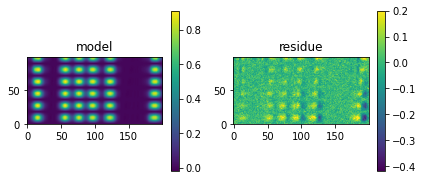

0.050719990597906404
-0.008771464401944212
Iteration 2:


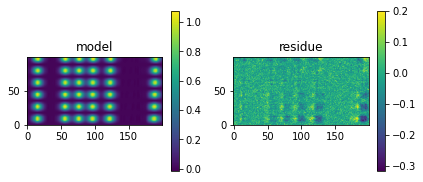

0.04627477725638213
-0.010257671772902687
Iteration 3:


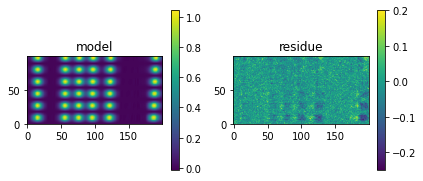

0.04413610675754727
-0.013097859077981718
Iteration 4:


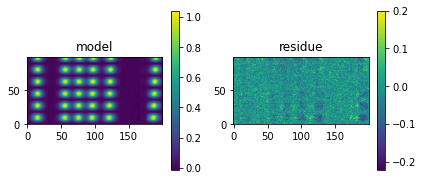

0.04289861170966691
-0.01503234803872789
Iteration 5:


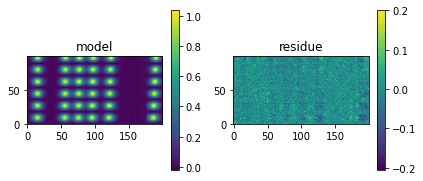

0.042192539244117436
-0.01634096797475629
Iteration 6:


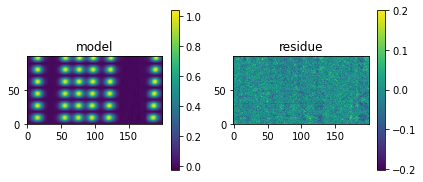

0.04178293658180788
-0.017216557822195853
Iteration 7:


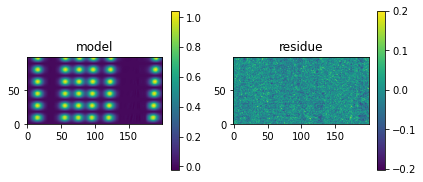

0.041609805027352356
-0.017822592157430775
Iteration 8:


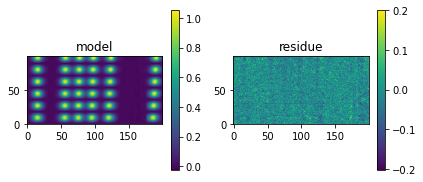

0.041430195833306455
-0.018203139523423822
Iteration 9:


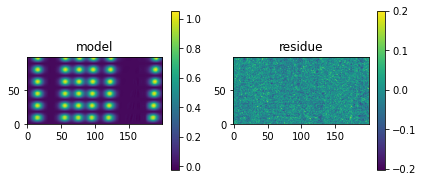

0.04140612110738082
-0.018494752818084766
Iteration 10:


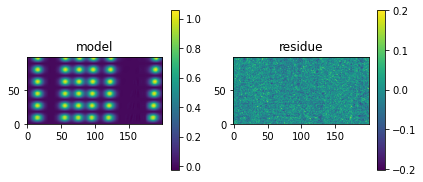

0.041360272755027884
-0.018741013033079554
Iteration 11:


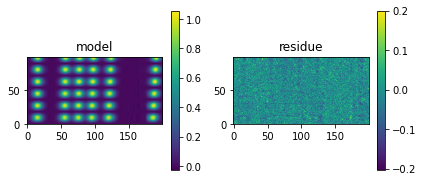

0.04134616575987699
-0.018950614260233038
Iteration 12:


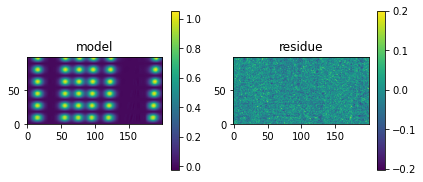

0.04133101665091854
-0.019109469149229227
Iteration 13:


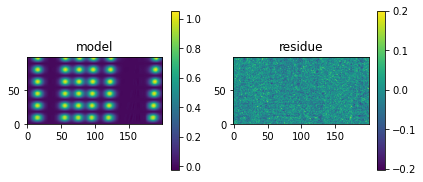

0.04134643346242899
-0.019222168136185054
Iteration 14:


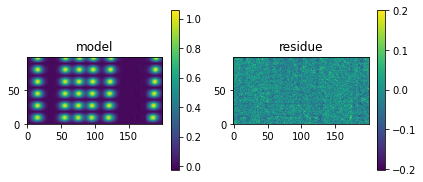

0.041325384222803394
-0.019317577159614775
Iteration 15:


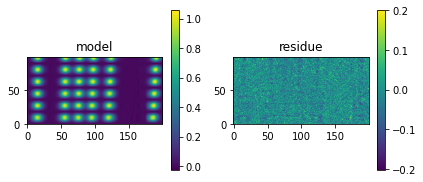

0.041326228542828435
-0.01938830611836148
Iteration 16:


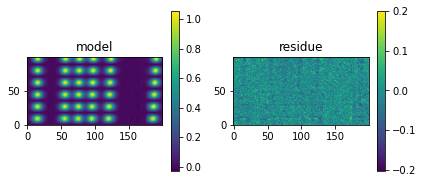

0.04131129950164842
-0.019440263047219845
Iteration 17:


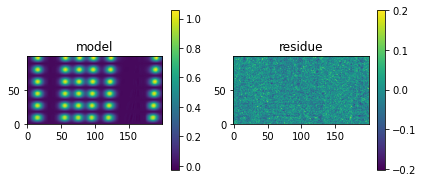

0.04133044056344899
-0.019483528705692987
Iteration 18:


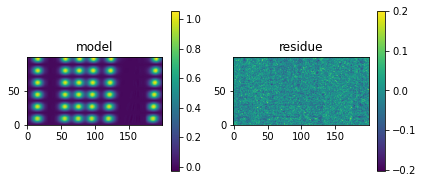

0.04131276670887279
-0.019516946640340066
Iteration 19:


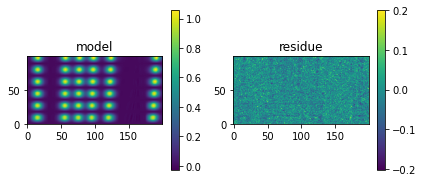

0.04131266217775084
-0.019543292759914205
Iteration 20:


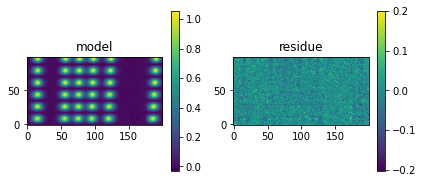

0.041307029260992445
-0.01956774150340646
Time elapsed is 409.8921263217926. Iterations: 20.


In [102]:
fit_parametersX = minimize_2Dspec_fouriershear(data_sim, 50, 50, 20, 4, 10) 

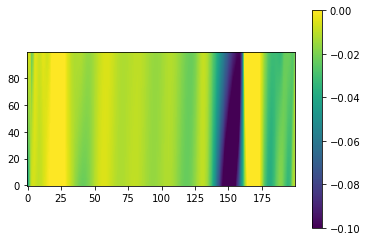

In [103]:
shear_field = fit_parametersX[2].reshape(np.shape(data_sim))
plt.imshow(shear_field, origin='lower', vmax=0, vmin=-0.1)
plt.colorbar()

(-0.06, 0.0)

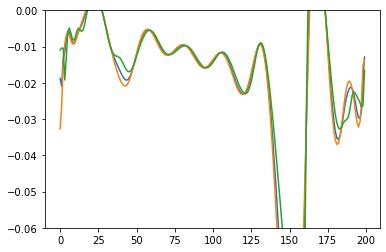

In [106]:
plt.plot(shear_field[40,:])
plt.plot(shear_field[20,:])
plt.plot(shear_field[80,:])
plt.ylim(-0.06,0)

In [212]:
def fourier_design_1D(x_array, n_freq, L):
    'In (column) list, cosines followed sines.'
#     assert 2*n_freq < len(x_array)
    
    k0 = 2*np.pi/L
    
    output_cos = [np.cos(k0*i*x_array) for i in range(n_freq)]
    output_sin = [np.sin(k0*i*x_array) for i in range(1,n_freq)]
    
    return np.concatenate((output_cos, output_sin)).T


def fourier_design_2Dortho(data, x_labels, y_labels, n_x, n_y, L_x, L_y):
    assert len(x_labels) == len(y_labels)
    assert len(x_labels) == len(data.flatten())

    fdesign_x = fourier_design_1D(x_labels,n_x, L_x)
    fdesign_y = fourier_design_1D(y_labels,n_y, L_y)
    
    return fdesign_x, fdesign_y

def shear_design(x_array, y_array):
    
    output = []
    output.append(np.ones_like(x_array))
    output.append(x_array)
    output.append(x_array**2)
    output.append(x_array**3)
    
    return np.array(output).transpose()

def shear_parameter_cofactor(design, parameters, orthocoord_vals, ortho_factors, L):
    assert len(design) == len(orthocoord_vals)
    assert len(orthocoord_vals) == len(ortho_factors)
    assert len(design[0]) == len(parameters)

    # Number of frequency (already implied by design matrix size)
    n_freq = int((len(design[0]) + 1)/2)
    
    # Design square but with the constant column removed
    design_square = np.delete(design, 0, axis=1)
    
    
    # Wavenumbers with absorbed sign (does not include k = 0)
    ks_signed = np.array([2*np.pi*i/L for i in range(1,n_freq)] \
                  +[2*np.pi*i/L for i in range(1,n_freq)])
    signs = np.array([1 for i in range(1,n_freq)] \
                  +[-1 for i in range(1,n_freq)])
    ks_signed = ks_signed*signs
    
    # Fourier coefficients with k = 0 removed
    para_square = np.delete(parameters, 0)
    para_square_rolled = np.roll(para_square, -(n_freq-1))

    # Finishing calculation...
    ks_signed_times_pararolled = ks_signed*para_square_rolled
    output = np.matmul(design_square,ks_signed_times_pararolled)
    output = output*orthocoord_vals*ortho_factors
    return output

def shear(data, weight_factors, orthodir_vals, orthodir_factors,\
          sheardir_factors, sheardir_design, sheardir_para, sheardir_L):
    correction_terms = shear_parameter_cofactor(sheardir_design, sheardir_para,\
                                                 orthodir_vals, orthodir_factors, sheardir_L)
    residual = data - sheardir_factors*orthodir_factors
    output = np.dot(residual*weight_factors, correction_terms)/ \
    np.dot(correction_terms*weight_factors, correction_terms)
    
    return output

epsilon_matrix = lambda x : np.array([[1 - x[0], x[1]],[x[2], 1- x[3]]])

In [213]:
def minimize_2Dspec_powershear(data, n_x, n_y, n_iter, n_Fourier_iter = 1, n_deform_iter = 10):
    start_time = time.time()
    
    #XXXX Defining constants and local functions XXXX#
    N = len(data)*len(data[0])
    data_flat = data.flatten()
    data_mean = np.mean(data_flat)
    L_x, L_y = 1, 1 # 2D-data normalized to unit square
    ##################################################
    
    
    #XXXX Initializing parameter and weight values XXXX#
    # Grid labels
    eta1_vals = np.arange(len(data[0]))/len(data[0]) # normalized to unit interval
    eta2_vals = np.arange(len(data[:,0]))/len(data[:,0]) # normalized to unit interval   
    eta1_mesh, eta2_mesh = np.meshgrid(eta1_vals,eta2_vals) # creating mesh
    eta1_flat, eta2_flat = eta1_mesh.flatten(), eta2_mesh.flatten() # vectorizing
    eta1_flat_ortho, eta2_flat_ortho = np.copy(eta1_flat), np.copy(eta2_flat) # storing orthogonal mesh
    
    # Fourier design matrices
    design_x, design_y = fourier_design_ortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
    
    # Fourier coefficients
    x, y = np.zeros(2*n_x - 1), np.zeros(2*n_y - 1)
    x[0], y[0], = 1, 1
    
    # Linear deformation parameters
    epsilon_xxs = np.zeros_like(data_flat)
    epsilon_xys = np.zeros_like(data_flat)
    epsilon_yxs = np.zeros_like(data_flat)
    epsilon_yys = np.zeros_like(data_flat)

    # Linear deformation parameters
    epsilon_xx = 0
    epsilon_xy = 0
    epsilon_yx = 0
    epsilon_yy = 0
    
    # Weights
    weights = np.ones_like(data_flat)
    ####################################################
    
    
    #XXXX Constructing handles for data model points XXXX#
    f = np.matmul(design_x,x) #function along the horizontal (x) evaluations
    g = np.matmul(design_y,y) #function along the vertical (y) evaluations
    ######################################################
    
    
    counter = 0
    
    while counter < n_iter:        
        counter += 1
        print(f'Iteration {counter}:')
        
        ##### Fourier fitting ##### 
        for i in range(n_Fourier_iter):

            ##### Solving f(x) parameters #####
            # Updating parameters
            design = np.array([design_x[i]*g[i] for i in range(len(design_x))])
            x = fit(data_flat, design, weights)[0]

            # Updating model-related values
            f = np.matmul(design_x,x)
            model_mean = np.mean(f*g)
            errors = np.abs(data_flat - np.matmul(design,x))
            weights = 1/np.clip(errors, model_mean, None)**2
            ###################################


            ##### Solving g(y) parameters #####
            # Updating parameters
            design = np.array([design_y[i]*f[i] for i in range(len(design_y))])
            y = fit(data_flat, design, weights)[0]

            # Updating model-related values
            g = np.matmul(design_y,y)
            model_mean = np.mean(f*g)
            errors = np.abs(data_flat - np.matmul(design,y))
            weights = 1/np.clip(errors, model_mean, None)**2
            ###################################
            
        
        ###########################
        
#         ##### Grid shearing #####
#         for i in range(n_deform_iter):
            
#             ##### Shearing along x #####           
#             epsilon_xy += shear(data_flat, weights, eta2_flat, g, f, design_x, x, 1)
#             deformation_matrix = epsilon_matrix([0,epsilon_xy,0,0])
            
#             etas_stacked = np.vstack((eta1_flat_ortho,eta2_flat_ortho)) 
#             etas_stacked = np.matmul(deformation_matrix, etas_stacked)    
#             eta1_flat[:] = etas_stacked[0,:]
#             eta2_flat[:] = etas_stacked[1,:]
            
#             design_x, design_y = fourier_design_2Dortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
#             f, g = np.matmul(design_x,x), np.matmul(design_y,y)
#             model_mean = np.mean(f*g)
#             errors = np.abs(data_flat - f*g)
#             weights = 1/np.clip(errors, model_mean, None)**2
#             ############################
        
        ##### Grid shearing #####

        for i in range(n_deform_iter):
            
            ##### Shearing along x #####        
            design_shear = shear_design(eta1_flat, eta2_flat)
            correction_terms = shear_parameter_cofactor(design_x, x, eta2_flat, g, 1)
            design = np.array([design_shear[i]*g[i]*correction_terms[i] for i in range(len(design))])            
            residual = data_flat - f*g        
            epsilon_xy_paras = fit(residual, design, weights)[0]           
            epsilon_xys += np.matmul(design_shear, epsilon_xy_paras)

            eta1_flat, eta2_flat = deform_local(eta1_flat_ortho, eta2_flat_ortho, epsilon_xys, epsilon_yxs)  
                         
            design_x, design_y = fourier_design_ortho(data, eta1_flat, eta2_flat, n_x, n_y, L_x, L_y)
            f, g = np.matmul(design_x,x), np.matmul(design_y,y)
            model_mean = np.mean(f*g)
            errors = np.abs(data_flat - f*g)
            weights = 1/np.clip(errors, model_mean, None)**2
            ############################      
            
    
        #########################
        
        
        #### Plotting intermediate models #####
        model = f*g
        residue = data_flat - model
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(model.reshape(np.shape(data)), origin='lower')
        im2 = ax2.imshow(residue.reshape(np.shape(data)), vmax = 0.2 ,origin='lower')
        ax1.set_title('model')
        ax2.set_title('residue')
        fig.colorbar(im1, ax=ax1, shrink=0.6)
        fig.colorbar(im2, ax=ax2, shrink=0.6)
        fig.tight_layout()
        plt.show()
        
        print(f'residue ave.: {np.mean(residue)}')
        print(f'shear ave.: {np.mean(epsilon_xys)}')
        #######################################
        
    
    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    
    return x, y, epsilon_xys, residue

Iteration 1:


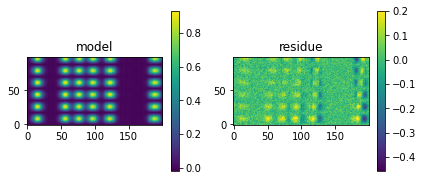

residue ave.: 0.0024265672587835303
shear ave.: -0.0031506459667834117
Iteration 2:


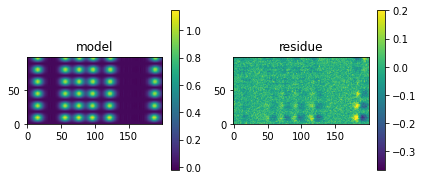

residue ave.: -0.010169403532872634
shear ave.: -0.006015811395315572
Iteration 3:


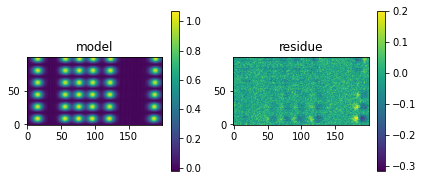

residue ave.: -0.009287514134946573
shear ave.: -0.008089522661823686
Iteration 4:


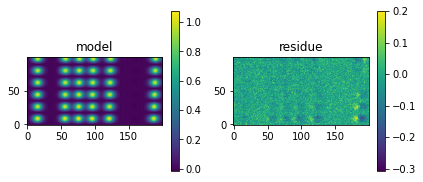

residue ave.: -0.007793764237933678
shear ave.: -0.009530816499580567
Iteration 5:


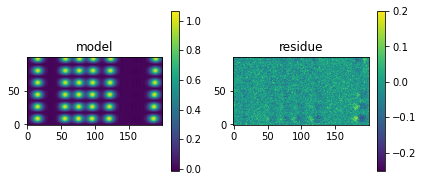

residue ave.: -0.0072121261849990076
shear ave.: -0.010573210264846464
Iteration 6:


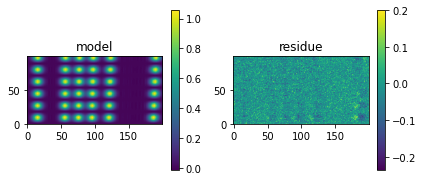

residue ave.: -0.006872466032902482
shear ave.: -0.011307990527869806
Iteration 7:


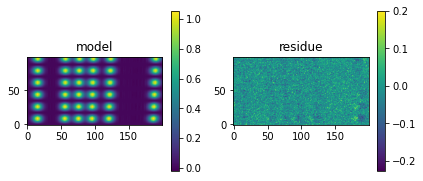

residue ave.: -0.0067494591324234
shear ave.: -0.011838765154452799
Iteration 8:


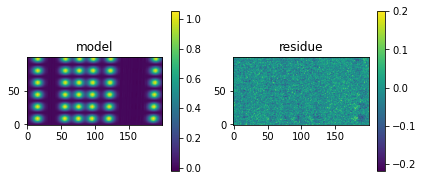

residue ave.: -0.006533438623833837
shear ave.: -0.012228151637542343
Iteration 9:


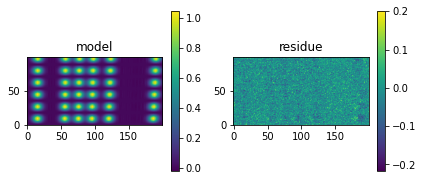

residue ave.: -0.006605876925682013
shear ave.: -0.01252122184060706
Iteration 10:


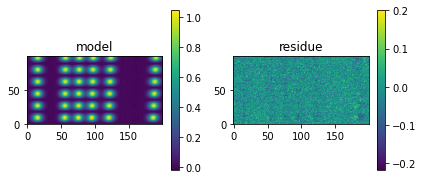

residue ave.: -0.006501851922446828
shear ave.: -0.012742722944567577
Iteration 11:


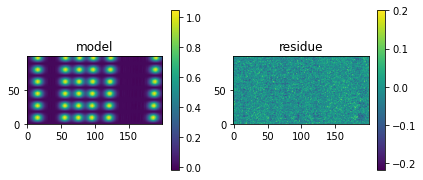

residue ave.: -0.0066190051618523526
shear ave.: -0.012913093580969152
Iteration 12:


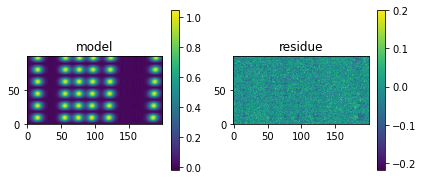

residue ave.: -0.006560067242967989
shear ave.: -0.01304469205826036
Iteration 13:


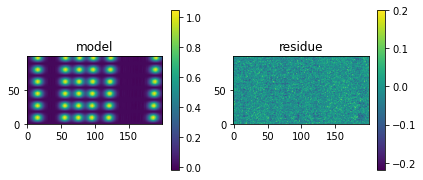

residue ave.: -0.006644466630000789
shear ave.: -0.013148240208180041
Iteration 14:


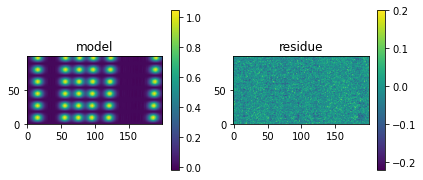

residue ave.: -0.006587137971974735
shear ave.: -0.013229473041867381
Iteration 15:


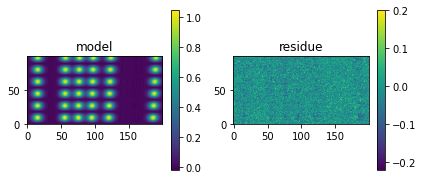

residue ave.: -0.006637735043778001
shear ave.: -0.013294248205377385
Time elapsed is 76.33910298347473. Iterations: 15.


In [222]:
spectra_model = minimize_2Dspec_powershear(data_sim, 100, 50, 15, 4, 4)

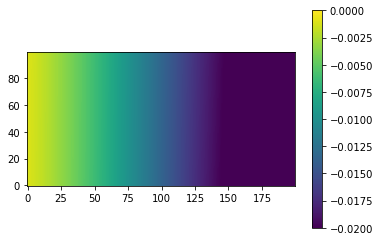

In [223]:
shear_field = spectra_model[2].reshape(np.shape(data_sim))
plt.imshow(shear_field, origin='lower', vmax=0, vmin=-0.02)
plt.colorbar()

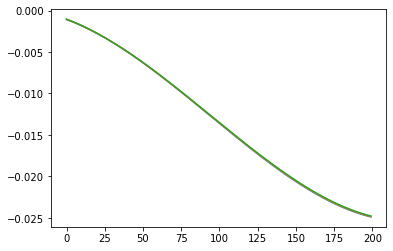

In [224]:
plt.plot(shear_field[20,:])
plt.plot(shear_field[40,:])
plt.plot(shear_field[60,:])

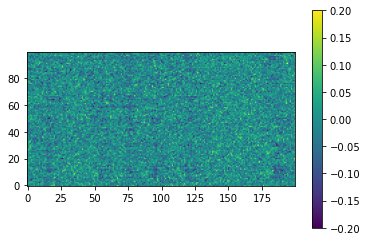

In [227]:
plt.imshow(spectra_model[3].reshape(np.shape(data_sim)), origin='lower', \
           vmax=0.2, vmin=-0.2)
plt.colorbar()